In [ ]:
import sys

sys.path.append('../../../')

import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score

from Pipeline.tf_dataset_builder import DatasetBuilderPipeline
from Pipeline.tf_lite_utils import predict_tflite, convert_tf_lite, convert_tf_lite_quantized, compare_size
from Pipeline.evaluation import plot_confusion_matrix

In [2]:
# Set seed for experiment reproducibility
seed = 1
tf.random.set_seed(seed)

In [3]:
# Define paths to model files
MODELS_DIR = '../../../Models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [4]:
class_dict = {
    'Background': 0,
    'Big mandibles': 1,
    'Small mandibles': 2,
}

In [5]:
# Set hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
class_weight = {0: 1.0, 1: 1.0, 2: 1.0}
patience = 15

In [6]:
# Load the data
DatasetBuilder = DatasetBuilderPipeline(
    #dataset_dir="../../../Dataset/Generated dataset/Deployment/unstandardized/50ms/**/*.wav",
    dataset_dir="../../../Dataset/Final dataset/Generation/Generated dataset/**/*.wav",
    batch_size=batch_size,
    class_dict=class_dict,
    augment=False,
    balanced=False,
    seed=seed,
    nfft=128,
    win_length=128,
    hop_length=64,
    min_freq=500,
    max_freq=14000,
)
train_dataset, val_dataset, test_dataset = DatasetBuilder.build(val_split=0.2, test_split=0.2)

In [7]:
input_shape = test_dataset[0][0].shape

In [8]:
input_shape

(39, 33, 1)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_dict), activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 33, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 17, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 17, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 9, 8)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 9, 8)          584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 8)          0

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=patience, restore_best_weights=True),
)

Epoch 1/100
30/30 [==============================] - 1s 21ms/step - loss: 1.1011 - accuracy: 0.3396 - val_loss: 1.0909 - val_accuracy: 0.4083
Epoch 2/100
30/30 [==============================] - 1s 17ms/step - loss: 1.0828 - accuracy: 0.3911 - val_loss: 1.0655 - val_accuracy: 0.4333
Epoch 3/100
30/30 [==============================] - 1s 16ms/step - loss: 1.0599 - accuracy: 0.4354 - val_loss: 1.0263 - val_accuracy: 0.5500
Epoch 4/100
30/30 [==============================] - 1s 16ms/step - loss: 1.0029 - accuracy: 0.5151 - val_loss: 0.9635 - val_accuracy: 0.5458
Epoch 5/100
30/30 [==============================] - 1s 17ms/step - loss: 0.9389 - accuracy: 0.5536 - val_loss: 0.9244 - val_accuracy: 0.5646
Epoch 6/100
30/30 [==============================] - 1s 19ms/step - loss: 0.8646 - accuracy: 0.6115 - val_loss: 0.8839 - val_accuracy: 0.5979
Epoch 7/100
30/30 [==============================] - 1s 17ms/step - loss: 0.8422 - accuracy: 0.6323 - val_loss: 0.8718 - val_accuracy: 0.5917
Epoch 

In [12]:
# Evaluate the model
test_features, y_true = test_dataset[0], test_dataset[1]
y_pred = np.argmax(model.predict(test_features), axis=1)

test_acc = accuracy_score(y_true, y_pred)
print(f'Classification test set accuracy: {test_acc:0.00%}')

19/19 [==============================] - 0s 4ms/step
Classification test set accuracy: 81%


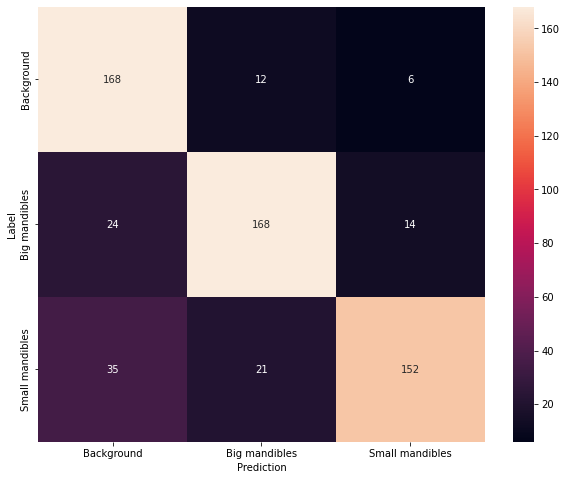

In [13]:
labels = list(class_dict.keys())
plot_confusion_matrix(labels, y_true, y_pred)

In [14]:
# Compress the model
model.save(MODEL_TF)
convert_tf_lite(MODEL_TF, MODEL_NO_QUANT_TFLITE)

INFO:tensorflow:Assets written to: ../../Models/model\assets


INFO:tensorflow:Assets written to: ../../Models/model\assets


Float model is 12584 bytes


In [15]:
def representative_dataset():
  for feature, label in train_dataset.take(100):
    yield {
      "input_1": feature.numpy(),
      "label": label.numpy(),
    }
convert_tf_lite_quantized(MODEL_TF, MODEL_TFLITE, representative_dataset, mode='8x8')

Quantized model is 7968 bytes


In [16]:
compare_size(model, batch_size, MODEL_NO_QUANT_TFLITE, MODEL_TFLITE)

,Size,
Model,,
TensorFlow,4557571 bytes,
TensorFlow Lite,12584 bytes,(reduced by 4544987 bytes)
TensorFlow Lite Quantized,7968 bytes,(reduced by 4616 bytes)


In [17]:
y_pred_float = predict_tflite(MODEL_NO_QUANT_TFLITE, test_features, y_true, model_type="Float", loss="categorical_crossentropy")

              precision    recall  f1-score   support

           0     0.7401    0.9032    0.8136       186
           1     0.8358    0.8155    0.8256       206
           2     0.8837    0.7308    0.8000       208

    accuracy                         0.8133       600
   macro avg     0.8199    0.8165    0.8130       600
weighted avg     0.8227    0.8133    0.8130       600



In [18]:
y_pred_quant = predict_tflite(MODEL_TFLITE, test_features, y_true, model_type="Quantized", loss="categorical_crossentropy")

              precision    recall  f1-score   support

           0     0.7325    0.8978    0.8068       186
           1     0.8038    0.8155    0.8096       206
           2     0.8834    0.6923    0.7763       208

    accuracy                         0.7983       600
   macro avg     0.8066    0.8019    0.7976       600
weighted avg     0.8093    0.7983    0.7972       600

